In [1]:
import os
import piexif
import cv2
from tqdm import tqdm
import numpy as np
from sklearn.model_selection import train_test_split
import keras as k
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras import optimizers
import matplotlib.pyplot as plt
import pandas as pd

Using TensorFlow backend.


In [2]:
img_size = 32
train_dir = "/Users/JG/Documents/Machine_Learning/Data/CervicalShape/Images/Train"
test_dir = "/Users/JG/Documents/Machine_Learning/Data/CervicalShape/Images/Test"

In [3]:
def PreProcess_Images(root, train=True):
    features = []
    labels = []
    
    for subdir, dirs, files in os.walk(root):
        for file in tqdm(files):
            if not file == ".DS_Store":
                img = os.path.join(subdir, file)
                #Remove exif data - This is because there is a lot of corrupt exif data in this dataset.
                piexif.remove(img)
                #Open image and resize to designated width and height. 
                im = cv2.imread(img)
                im = cv2.resize(im, (img_size, img_size))
                #Extract features into a numpy array.
                feature = np.array(im, dtype=np.float32)
                #append feature to features list.
                features.append(feature)
                
                #only apply labels for training data. 
                if train == True:
                    #Get label from directory name.
                    label = os.path.basename(subdir)
                    if label == "1":
                        label = [1,0,0]
                    elif label == "2":
                        label = [0,1,0]
                    else:
                        label = [0,0,1]
                        
                    labels.append(label)
                    labels = np.array(labels, np.uint8)
                else:
                    label = os.path.basename(img)
                    labels.append(label)
    
    features = np.array(features, np.float32) / 255.
    
    return features, labels

In [61]:
X, y = PreProcess_Images(train_dir, train=True)

100%|██████████| 451/451 [03:53<00:00,  2.27it/s]


In [115]:
X_test, flnm_test = PreProcess_Images(test_dir, train=False)

100%|██████████| 512/512 [05:00<00:00,  1.90it/s]


In [62]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.20, random_state=42)

In [66]:
np.savez('data_arrays', X_train, y_train, X_valid, y_valid, X_test, y_test)

In [67]:
with np.load('data_arrays.npz') as data:
    xtr = data['arr_0']
    ytr = data['arr_1']
    xvl = data['arr_2']
    yvl = data['arr_3']
    xts = data['arr_4']
    yts = data['arr_5']

In [95]:
#Quick Keras Model
model = Sequential()
model.add(ZeroPadding2D((1,1),input_shape=(32,32,3)))
model.add(Conv2D(32, (3, 3),activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.6))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(lr=0.1, momentum=0.1, decay=0.0),
              metrics=['accuracy']
             )

In [96]:
#Train model and save information to history for plotting.
history = model.fit(xtr, ytr,
          batch_size=128,
          epochs=30,
          verbose=1,
          validation_data=(xvl, yvl))

Train on 1184 samples, validate on 297 samples
Epoch 1/30
1184/1184 [==============================] - 5s - loss: 1.0304 - acc: 0.5279 - val_loss: 1.0393 - val_acc: 0.4613
Epoch 2/30
1184/1184 [==============================] - 4s - loss: 1.0020 - acc: 0.5439 - val_loss: 1.0401 - val_acc: 0.4613
Epoch 3/30
1184/1184 [==============================] - 4s - loss: 0.9908 - acc: 0.5439 - val_loss: 1.0426 - val_acc: 0.4613
Epoch 4/30
1184/1184 [==============================] - 4s - loss: 0.9970 - acc: 0.5439 - val_loss: 1.0193 - val_acc: 0.4613
Epoch 5/30
1184/1184 [==============================] - 4s - loss: 0.9906 - acc: 0.5456 - val_loss: 1.0922 - val_acc: 0.4613
Epoch 6/30
1184/1184 [==============================] - 4s - loss: 0.9882 - acc: 0.5439 - val_loss: 1.0180 - val_acc: 0.4613
Epoch 7/30
1184/1184 [==============================] - 4s - loss: 0.9817 - acc: 0.5431 - val_loss: 1.0232 - val_acc: 0.4613
Epoch 8/30
1184/1184 [==============================] - 4s - loss: 0.9645 - ac

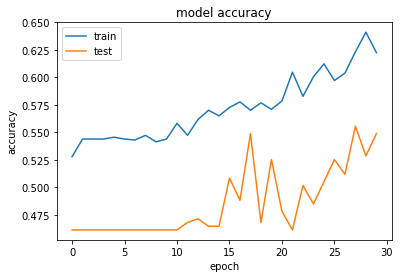

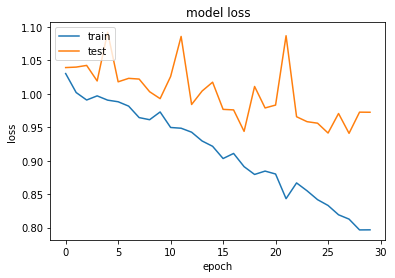

In [97]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [118]:
#Create Prediction File(.csv)
test_predictions = model.predict(xts, batch_size=32, verbose=0)
test_data = np.column_stack((flnm_test,test_predictions))
dfPreds = pd.DataFrame(data=test_data,columns=['image_name','Type_1','Type_2','Type_3'])
dfPreds.to_csv('submission_1.csv', index=False)